# IBM Advanced Data Science Capstone: Forecasting Stock Prices

## Extract-Transform-Load (ETL) 

### Feature Engineering

-  We have already exraced the Year and Month from the `Date` during the data cleaning step. This will help us capture the sesonal aspects and get time-based aggregations at granular time-steps. 
- Created a new calculated feature `Daily_Return` of a RIC on a given day which will be defined as `Daily_Return = (Price_Open) - (Price_Close)`. As per the EDA recommendations we are creating this additional feature to avoid any potential multicollinearity due to opening and closing stock prices. 
- Apply the neccessary aggregations on the numerical features for stock prices and volume based on the categorical features.  
- Index the string datatype feature(s) into numerical values so that they are compatible if we are to use in the feature set for the Machine Learning/Deep Learning models.
- Create feature vectors from the raw features and analyze their importances to the highest stock price. We will use the Random Forest Regression Model from PySpark's ML libary.
- At this stage, we are only analzying the feature importances and not building the model. We will use insights from the Random Forest to evaluate the features and put them together with the correlations we got from the Multivariate Analysis. 
- After hyperparameter tuning in the next phase, we might revisit this phase to find ways to improve the model performance using the findings of feature engineering.  

In [1]:
# find and init the spark instance to ensure it is pip installed
import findspark
findspark.init()

# set some HTML display setting 
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

# import all the pyspark dependencies 
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.types import StructType, StructField, DoubleType, IntegerType, StringType, DateType
from pyspark.sql.functions import *
import pyspark.sql.functions as F

from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor

# declare a spark object that we will run our spark SQL dataframes on 
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

# init a spark session 
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .getOrCreate()

# import basic data analysis libraries  
import numpy as np
import pandas as pd
import scipy.stats as stats

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# import libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

### Import the cleansed data files into spark dataframes

In [2]:
data_stocks_cleaned = spark.read.csv('kaggle_stock_data_cleansed.csv', header=True)
data_stocks_cleaned.show(5)

+----------+----------+----------+-----------+----------+------+----+-----+
|Instrument|      Date|Price_High|Price_Close|Price_Open|Volume|Year|Month|
+----------+----------+----------+-----------+----------+------+----+-----+
|   123F.DE|2021-11-05|11.7559152| 11.6562888|11.7559152|   104|2021|   11|
|   123F.DE|2021-11-12| 11.457036| 11.2577832| 11.457036|   650|2021|   11|
|   123F.DE|2021-11-24|11.6562888| 11.1581568|11.6562888|  2184|2021|   11|
|   123F.DE|2021-11-29|11.7559152| 11.5566624|11.5566624|  4880|2021|   11|
|   123F.DE|2021-11-16|11.0585304|  10.958904|11.0585304|   946|2021|   11|
+----------+----------+----------+-----------+----------+------+----+-----+
only showing top 5 rows



In [3]:
data_sectors_cleaned = spark.read.csv('kaggle_stock_sector_information_cleansed.csv', header=True)
data_sectors_cleaned.show(5)

+----------+--------------------+-------------------------+-------------------------+------------------------+--------------------+--------------------+-------------------------+-------------------------+------------------------+------------------+------------------+
|Instrument| Company_Common_Name|TRBC_Economic_Sector_Name|TRBC_Business_Sector_Name|TRBC_Industry_Group_Name|  TRBC_Industry_Name|  TRBC_Activity_Name|TRBC_Economic_Sector_Code|TRBC_Business_Sector_Code|TRBC_Industry_Group_Code|TRBC_Industry_Code|TRBC_Activity_Code|
+----------+--------------------+-------------------------+-------------------------+------------------------+--------------------+--------------------+-------------------------+-------------------------+------------------------+------------------+------------------+
|   SPEXN.S|           Spexis AG|               Healthcare|     Pharmaceuticals &...|         Pharmaceuticals|     Pharmaceuticals|  Biopharmaceuticals|                       56|                  

### Create a new feature Daily_Return as the difference of opening and closing daily stock prices respectively

In [4]:
data_stocks_cleaned = data_stocks_cleaned.withColumn('Daily_Return', round(col('Price_Open') - col('Price_Close'),3))
data_stocks_cleaned.show(5)

+----------+----------+----------+-----------+----------+------+----+-----+------------+
|Instrument|      Date|Price_High|Price_Close|Price_Open|Volume|Year|Month|Daily_Return|
+----------+----------+----------+-----------+----------+------+----+-----+------------+
|   123F.DE|2021-11-05|11.7559152| 11.6562888|11.7559152|   104|2021|   11|         0.1|
|   123F.DE|2021-11-12| 11.457036| 11.2577832| 11.457036|   650|2021|   11|       0.199|
|   123F.DE|2021-11-24|11.6562888| 11.1581568|11.6562888|  2184|2021|   11|       0.498|
|   123F.DE|2021-11-29|11.7559152| 11.5566624|11.5566624|  4880|2021|   11|         0.0|
|   123F.DE|2021-11-16|11.0585304|  10.958904|11.0585304|   946|2021|   11|         0.1|
+----------+----------+----------+-----------+----------+------+----+-----+------------+
only showing top 5 rows



### Aggregate over the categorical features and transform the numerical features 

In [5]:
data_stocks_cleaned = data_stocks_cleaned.filter((data_stocks_cleaned.Year >= 2019) & (data_stocks_cleaned.Year <= 2023))
data_stocks_agg = data_stocks_cleaned.groupBy("Instrument","Year","Month").agg(
    round(avg(col("Price_High")), 2).alias("Avg_Price_High"),
    round(avg(col("Price_Open")), 2).alias("Avg_Price_Open"),
    round(avg(col("Price_Close")), 2).alias("Avg_Price_Close"),
    round(avg(col("Daily_Return")), 2).alias("Avg_Daily_Return"),
    round(avg(col("Volume")), 2).alias("Avg_Daily_Volume"),
    round(sum(col("Volume")), 2).alias("Total_Volume")
).sort(["Instrument","Year","Month"],ascending=[True, True, True])
data_stocks_agg.show(10)

+----------+----+-----+--------------+--------------+---------------+----------------+----------------+------------+
|Instrument|Year|Month|Avg_Price_High|Avg_Price_Open|Avg_Price_Close|Avg_Daily_Return|Avg_Daily_Volume|Total_Volume|
+----------+----+-----+--------------+--------------+---------------+----------------+----------------+------------+
|   123F.DE|2021|   11|         11.56|         11.47|           11.4|            0.07|          1761.0|     33459.0|
|   123F.DE|2021|   12|         11.96|         11.85|          11.81|            0.04|         4547.45|     90949.0|
|   123F.DE|2022|    1|         12.69|         12.51|          12.55|           -0.04|         1465.39|     26377.0|
|   123F.DE|2022|   10|          6.77|          6.69|           6.67|            0.02|         1103.64|     15451.0|
|   123F.DE|2022|   11|          6.42|           6.4|           6.25|            0.14|         2003.89|     18035.0|
|   123F.DE|2022|   12|          5.96|          5.81|           

### Feature Creation 

1. Use the String Index to encode the categorical feature `Instrument` into a numerical representation.
2. Define a feature set and create a feature vector from that using the Vector Assembler.  
3. Split the dataset into 80% of training data and 20% test data from vectorized dataframe. 
4. Define a Random Forest Regression Model with general hyperparameters and fit it on the 80% training data. 
5. Extract and Visualize the feature importance for a given target feature. Repeat 4 and 5 for all target features. 

#### Step-1: Use StringIndexer() to encode the 'Instrument' name

In [6]:
# create a stringIndexer() object and pass the features to be encoded 
indexer = StringIndexer(inputCol="Instrument", outputCol="Instrument_Encoded")
data_stocks_agg_idx = indexer.fit(data_stocks_agg).transform(data_stocks_agg)
data_stocks_agg_idx.show(5) 

+----------+----+-----+--------------+--------------+---------------+----------------+----------------+------------+------------------+
|Instrument|Year|Month|Avg_Price_High|Avg_Price_Open|Avg_Price_Close|Avg_Daily_Return|Avg_Daily_Volume|Total_Volume|Instrument_Encoded|
+----------+----+-----+--------------+--------------+---------------+----------------+----------------+------------+------------------+
|   123F.DE|2021|   11|         11.56|         11.47|           11.4|            0.07|          1761.0|     33459.0|             382.0|
|   123F.DE|2021|   12|         11.96|         11.85|          11.81|            0.04|         4547.45|     90949.0|             382.0|
|   123F.DE|2022|    1|         12.69|         12.51|          12.55|           -0.04|         1465.39|     26377.0|             382.0|
|   123F.DE|2022|   10|          6.77|          6.69|           6.67|            0.02|         1103.64|     15451.0|             382.0|
|   123F.DE|2022|   11|          6.42|          

#### Step-2: Define a feature set and create a feature vector

In [7]:
# test all possible numerical features in the feature set that can be used to predict the highest stock price 
feature_set = ["Avg_Price_Open", "Avg_Price_Close","Avg_Daily_Volume", "Avg_Daily_Return", "Total_Volume"]

# create a VectorAssembler() object to vectorize the feature set into one column 
assembler = VectorAssembler(inputCols=feature_set, outputCol="features")

# transform the indexed dataframe and aggregated dataframe 
data_stocks_agg_assembled = assembler.transform(data_stocks_agg_idx)
data_stocks_agg_assembled.show(5)

+----------+----+-----+--------------+--------------+---------------+----------------+----------------+------------+------------------+--------------------+
|Instrument|Year|Month|Avg_Price_High|Avg_Price_Open|Avg_Price_Close|Avg_Daily_Return|Avg_Daily_Volume|Total_Volume|Instrument_Encoded|            features|
+----------+----+-----+--------------+--------------+---------------+----------------+----------------+------------+------------------+--------------------+
|   123F.DE|2021|   11|         11.56|         11.47|           11.4|            0.07|          1761.0|     33459.0|             382.0|[11.47,11.4,1761....|
|   123F.DE|2021|   12|         11.96|         11.85|          11.81|            0.04|         4547.45|     90949.0|             382.0|[11.85,11.81,4547...|
|   123F.DE|2022|    1|         12.69|         12.51|          12.55|           -0.04|         1465.39|     26377.0|             382.0|[12.51,12.55,1465...|
|   123F.DE|2022|   10|          6.77|          6.69|     

#### Step-3: Split the data into training and testing sets

In [10]:
# training data -> from Jan 2019 to Sept 2022 and the test will be from Sept 2022 to Oct 2023
# we are using an uncovential train-test split as it is a time-series data and we need to consider the sequential aspects   
# (train_data, test_data) = data_stocks_agg_assembled.randomSplit([0.8, 0.2], seed=42)

train_data = data_stocks_agg_assembled.filter(
    (col("Year") < 2022) |
    ((col("Year") == 2022) & (col("Month") <= 9))
)

train_data = train_data.sort(['Instrument_Encoded','Year','Month'], ascending=[True, True, True])

test_data = data_stocks_agg_assembled.filter(
    ((col("Year") == 2022) & (col("Month") >= 9)) |
    ((col("Year") == 2023) & (col("Month") <= 9))
)
test_data = test_data.sort(['Instrument_Encoded','Year','Month'], ascending=[True, True, True])

**Note:** *In this phase, we are not building the model but only calculating feature importances based on the training data. So, we will not be predicting the stock price on the test or the validation data yet. This will be done in the next phase.*

#### Step-4: Define a Random Forest Regressor and fit it on the training data 

In [11]:
# define the random forest regressor object - calculate the feature importances against the target Average Highest Price 
rf = RandomForestRegressor(featuresCol="features", labelCol="Avg_Price_High", numTrees=100)

# fit it on the 80% training data 
model = rf.fit(train_data)
print("RF model fit compiled ...")

RF model fit compiled ...


#### Step-5: Extract and Visualize The Feature Importances 

In [12]:
# init an empty dictionary to store the feature importances for Avg closing price
_dict_price_high = {}
# get the feature importances for the avg close price
feature_importances = model.featureImportances

print("Feature Importances For Highest Price: \n")
for i, col in enumerate(feature_set):
    print(f"{col}: {feature_importances[i]}")
    _dict_price_high[col] = model.featureImportances[i] # add the feature importance to dict

Feature Importances For Highest Price: 

Avg_Price_Open: 0.4409175187775789
Avg_Price_Close: 0.4446822947426917
Avg_Daily_Volume: 0.028642526478884336
Avg_Daily_Return: 0.06285003212305144
Total_Volume: 0.02290762787779367


In [13]:
'''
plot_bar() : a function to plot a matplotlib bar chat based on the params 
@params : title - set the title of the plot, data - the dictionary holding the feature importance values 
'''
def plot_bar(title, data):
    
    # Sort the data in descending order of importance
    sorted_data = dict(sorted(data.items(), key=lambda x: x[1], reverse=True))
    
    # Extract feature names and importance values
    features = list(sorted_data.keys())
    importance_values = list(sorted_data.values())
    
    # Create a bar chart using Matplotlib
    plt.figure(figsize=(10, 6))
    bars = plt.bar(features, importance_values)
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title(title)
    plt.xticks(rotation = 45)
      # Invert the y-axis to show the most important features at the top
    plt.show()

print("Function plot_bar() compiled ... ")

Function plot_bar() compiled ... 


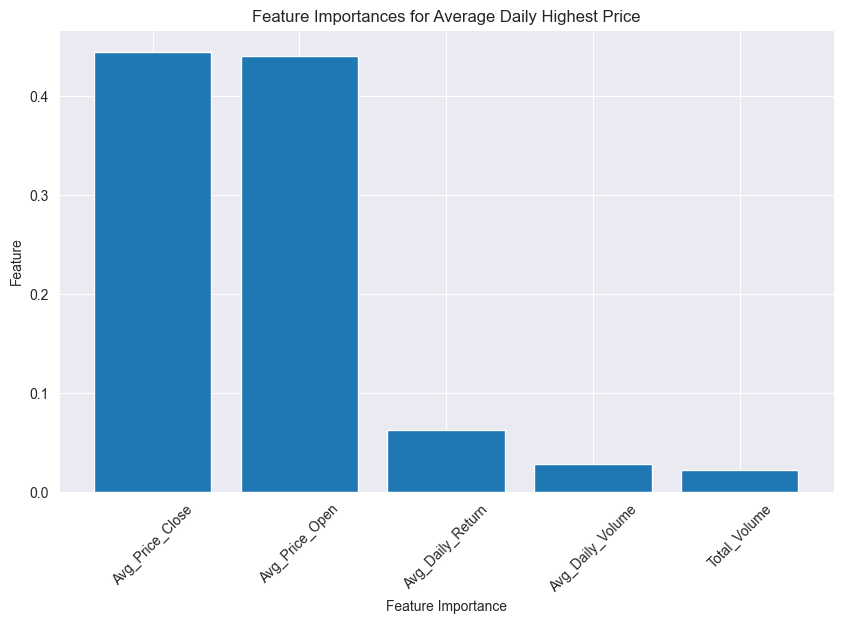

In [14]:
plot_bar('Feature Importances for Average Daily Highest Price', _dict_price_high)

#### Observations: 

- The `Avg_Price_Close` and the `Avg_Opening_Price` represent the highest feature importances to the target `Avg_Price_High`.
- It means the daily closing and opening stock prices are strong indicators of market sentiment and the potential price movement towards its peak during a given day.
- The `Total_Volume` and `Avg_Daily_Return` have a comparatively lower importance to the target `Avg_Price_High`. 

### Findings: 

- Putting together the insights we got from the Multivariate Analysis in EDA, we can conclude the Opening and Closing daily stock prices are the strongest indicators of the highest stock price.
- Not only they have a strong correlation, but also very high feature importance of 44% percentage each. It means put together, they impact 88% of the prediction for highest stock price.
- The additional feature we created does not have a strong feature importance to the highest stock price. But we can include it in the feature set as it is created from the two strongest impactful features. We can always get back retune the parameters based on the performance.
- The daily trading volume has a very low correlation to the highest stock price. As per the Multivariate Analysis, it did not have a strong correlation either. So, it may not be prudent to include it in the feature or else it could skew the predictions. 

### Recommendations 

Based on the findings, we can create the feature set in two ways:
- `Avg_Price_High` : `{Avg_Price_Open, Avg_Price_Close}`
- `Avg_Price_High` : `{Avg_Price_Open, Avg_Price_Close, Avg_Daily_Return}`
- First, we will use the most importance features Opening and Closing prices. We will train, test and predict using the two features in our model configuration.
- Then, we will add the daily return as well to the feature set. Then, we compare the model performances in both scenario. We will use the Regression Testing metrics like RMSE, MAE and MAPE to compare them. We will analyze whether the performance improves or not and report it back here. 
- * Iteration results - the feature set `{Avg_Price_Open, Avg_Price_Close}` gives the better result. So, we will use this in the data product. 
- Whichever feature gives the better results, we will use it in our final deployment.


### Join the Transformed Stocks Data with the Sector Information Data on the RIC 

In [15]:
# Create temporary views on the dataframes to be used as SQL tables 
# We will save the aggregated dataframe and apply the Regression transformations again in Model Training and Hyperparamter tuning 

data_stocks_agg.createOrReplaceTempView("STOCKS")
data_sectors_cleaned.createOrReplaceTempView("SECTORS")

# Perform an INNER join based on the RIC and merge the sector information 
data_stocks_transformed = spark.sql("select * from STOCKS st JOIN SECTORS se ON st.Instrument == se.Instrument") 
data_stocks_transformed.show(5)

+----------+----+-----+--------------+--------------+---------------+----------------+----------------+------------+----------+--------------------+-------------------------+-------------------------+------------------------+--------------------+--------------------+-------------------------+-------------------------+------------------------+------------------+------------------+
|Instrument|Year|Month|Avg_Price_High|Avg_Price_Open|Avg_Price_Close|Avg_Daily_Return|Avg_Daily_Volume|Total_Volume|Instrument| Company_Common_Name|TRBC_Economic_Sector_Name|TRBC_Business_Sector_Name|TRBC_Industry_Group_Name|  TRBC_Industry_Name|  TRBC_Activity_Name|TRBC_Economic_Sector_Code|TRBC_Business_Sector_Code|TRBC_Industry_Group_Code|TRBC_Industry_Code|TRBC_Activity_Code|
+----------+----+-----+--------------+--------------+---------------+----------------+----------------+------------+----------+--------------------+-------------------------+-------------------------+------------------------+---------

### Save the transformed dataframe to file 

In [16]:
data_stocks_transformed.toPandas().to_csv('kaggle_stock_data_transformed.csv', header=True, index=False, mode='w')